# Installation and Imports

In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [36]:
import math
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import time
import tracemalloc
from tensorflow.keras.regularizers import l2

In [37]:
import scvi

In [38]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

scanpy==1.9.6 anndata==0.9.2 umap==0.5.7 numpy==1.19.5 scipy==1.10.1 pandas==1.4.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


# Defined Methods

## Data Preprocessing

In [39]:
def data_init(path):
    print("\n==========================  Data Initialization  =================================\n")
    data = pd.read_csv(path, index_col=0).astype('float64')
    clusters = data.columns
    clusters = [int(x) for x in [float(x) for x in clusters]]
    adata = sc.AnnData(X=(data.values.T))
    adata.var_names = data.index
    adata.obs_names = [f"cell-{i}" for i in range(1, len(clusters) + 1)]
    adata.obs["cluster"] = clusters
    print("Loaded Dataset Structure: ")
    print((pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)).iloc[:10, :10])
    print(adata)
    print(f'Total Clusters: \n{np.unique(adata.obs["cluster"])}')
    print(f'Clusters: \n{adata.obs["cluster"]}')
    sc.pp.pca(adata, n_comps=50) 
    sc.pp.neighbors(adata, n_pcs=50)
    sc.tl.umap(adata)
    print("Existing Cluster")
    sc.pl.umap(adata, color='cluster')
    return adata


In [40]:
def data_processing(adata):
  print("\n==========================  Data Processing  =================================\n")
  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)
  sc.pp.normalize_per_cell(adata)
  sc.pp.log1p(adata, copy=True)
  return adata


## Denoising

In [41]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import numpy as np

def Denoise(adata):
    
    # Step 1: Load and preprocess data
    X = adata.X  # Assuming adata.X is in sparse format
    X = X.toarray() if hasattr(X, "toarray") else X  # Convert to dense if sparse
    
    # Normalize and scale data
    X = sc.pp.log1p(X, copy=True)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Step 2: Add sparse noise to mimic biological dropout
    def add_sparse_noise(data, dropout_rate=0.1):
        """
        Adds sparse dropout noise to mimic missing data in scRNA-seq.
        """
        noisy_data = data.copy()
        mask = np.random.binomial(1, dropout_rate, size=data.shape)  # Create dropout mask
        noisy_data[mask == 1] = 0  # Set selected values to zero
        return noisy_data
    
    X_noisy = add_sparse_noise(X)
    
    # Step 3: Define sparse-aware denoising autoencoder
    input_dim = X.shape[1]
    
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    latent_space = Dense(128, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(512, activation='relu')(latent_space)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
    # Custom sparse-aware loss
    def sparse_mse(y_true, y_pred):
        """
        Custom loss to preserve zeros and penalize large changes to nonzero values.
        """
        mask = tf.cast(tf.equal(y_true, 0.0), tf.float32)  # Mask for zeros in original data
        nonzero_loss = tf.reduce_mean(tf.square((1 - mask) * (y_true - y_pred)))  # Penalize changes to nonzeros
        zero_loss = tf.reduce_mean(tf.square(mask * y_pred))  # Penalize predicted values where true value is zero
        return nonzero_loss + 0.1 * zero_loss  # Combine losses with weight for zero preservation
    
    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss=sparse_mse,
                        metrics=['mae'])
    
    # Step 4: Train the model
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
    X_noisy_train, X_noisy_val = train_test_split(X_noisy, test_size=0.2, random_state=42)
    
    history = autoencoder.fit(
        X_noisy_train, X_train,
        validation_data=(X_noisy_val, X_val),
        epochs=200,
        batch_size=256,
        shuffle=True,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]
    )
    
    # Step 5: Denoise the data
    X_denoised = autoencoder.predict(X_noisy)
    
    # Save the denoised output
    adata.X = scaler.inverse_transform(X_denoised)  # Inverse scaling
    return adata


## Clustering

In [42]:
def cluster_with_louvain(adata, epochs, resolution=2.5):
  print("\n========================== Clustering With Louvain =================================\n")
  # if "X_pca" not in adata.obsm and "neighbors" not in adata.uns:
  sc.pp.pca(adata)
  sc.pp.neighbors(adata)
  sil_scores = []

  for i in range(0, epochs):
    sc.tl.louvain(adata, resolution)

    print(f"\nClustering epoch {i+1} ------------------")
    ari = adjusted_rand_score(adata.obs['cluster'], adata.obs['louvain'])
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    nmi = normalized_mutual_info_score(adata.obs['cluster'], adata.obs['louvain'])
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    X = adata.obsm["X_pca"]
    sil_score = silhouette_score(X, adata.obs['louvain'])
    sil_scores.append(sil_score)
    print(f"Silhouette Score: {sil_score:.4f}\n")

      
  sc.tl.umap(adata)
  sc.pl.umap(adata, color='louvain')
  return sil_scores

## Identify Marker Gene

### CellTICS

In [43]:
# Define fphi - High markers
def fphi(x):

    # Step 1: Normalized by max value (x + 1) / (max(x) + 1)
    normalized = (x + 1).div(x.max(axis=1) + 1, axis=0)

    # Step 2: Suppression factor (zt)
    zt = (1 - normalized).sum(axis=1) / (x.shape[1] - 1)

    # Step 3: phi values after applying suppression factor
    zp = normalized.mul(zt, axis=0)

    return zp

# Define frho - Low markers
def frho(x):
    # Step 1: Normalized by min value (1 / (x + 1)) * (min(x) + 1)
    normalized = (1 / (x + 1)).mul(x.min(axis=1) + 1, axis=0)

    # Step 2: Enhancement factor (zt)
    zt = (1 - normalized).sum(axis=1) / (x.shape[1] - 1)

    # Step 3: rho values after applying enhancement factor
    zp = normalized.mul(zt, axis=0)

    return zp



# thr1 -> high marker quantile | thr2 -> Low marker quantile
def CellTICS_marker_genes(adata, thr1=0.95, thr2=0.9):
  print("\n====================== Identify Marker Gene With CellTICS ============================\n")
  print("Expression Values of Genes: \n")
  expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
  louvain_labels = pd.Series(adata.obs['louvain'].values, index=adata.obs_names)
  print(expr_data.iloc[:10, :10])
  print(adata)

  print("\nAverage the cell expr data according to the clusters:\n")
  avg_expr_data = expr_data.T.groupby(louvain_labels).mean().T
  print(avg_expr_data.iloc[:10, :])

  phi = fphi(avg_expr_data)
  rho = frho(avg_expr_data)


  gnm = phi.index.values 
  ctpnm = phi.columns.values


  phi = np.array(phi)
  rho = np.array(rho)


  nummkg1 = math.ceil((1 - thr1) * phi.shape[0]) 
  nummkg2 = math.ceil((1 - thr2) * phi.shape[0]) 


  alpha = [] 
  beta = []
  for i in range(0, phi.shape[1]):
      alpha.append(np.quantile(phi[:, i], thr1))
      beta.append(np.quantile(rho[:, i], thr2))



  mkh = [] 
  mkl = [] 
  for i in range(0, phi.shape[1]):
      high_markers = gnm[phi[:, i] >= alpha[i]][0:nummkg1]
      low_markers = gnm[rho[:, i] >= beta[i]][0:nummkg2]
      mkh = np.concatenate([mkh, high_markers], axis=0) if len(mkh) > 0 else high_markers
      mkl = np.concatenate([mkl, low_markers], axis=0) if len(mkl) > 0 else low_markers


  mkh = mkh.reshape(nummkg1, phi.shape[1])
  mkl = mkl.reshape(nummkg2, rho.shape[1])
  mkh = pd.DataFrame(mkh, columns=ctpnm)
  mkl = pd.DataFrame(mkl, columns=ctpnm)

  print("\nHigh Marker Genes for each cluster/type: \n")
  print(mkh.iloc[:10, :])

  print("\nLow Marker Genes for each cluster/type: \n")
  print(mkl.iloc[:10, :])

  return mkh, mkl



In [44]:
# getting list of all high and low marker genes
def get_unique_marker_genes(high_markers):
  unique_high_markers = high_markers
  unique_high_markers = pd.unique(unique_high_markers.values.ravel()).tolist()
  print(f"\nTotal Unique High Marker Gene for all together {len(unique_high_markers)}: ")
  return unique_high_markers



## Calculate Importance

In [45]:
def calculate_importance(silhouette_scores):
    avg_scores = {k: sum(v) / len(v) for k, v in silhouette_scores.items()}
    
    total = sum(avg_scores.values())
    return {k: v / total for k, v in avg_scores.items()}

## Unified Marker Genes (Weight Based)

In [46]:
from collections import defaultdict

def score_marker_genes(celltics_genes, smash_genes, cosg_genes, importance, p=1.0):
    
    gene_weights = defaultdict(float)
    
    for gene in celltics_genes:
        gene_weights[gene] += importance['celltics']
        
    for gene in smash_genes:
        gene_weights[gene] += importance['smash']
        
    for gene in cosg_genes:
        gene_weights[gene] += importance['cosg']
    
    selected_genes = sorted(gene_weights.items(), key=lambda x: x[1], reverse=True) # selecting genes with highest weight

    print(f'total genes: {len(selected_genes)}')
    
    top_n = int(len(selected_genes) * p)

    print(f'selected genes: {top_n}')
    
    return [gene for gene, weight in selected_genes[:top_n]]

# Implementations____________


==========================  Data Initialization  =================================

Loaded Dataset Structure: 
Gene        Itm2a      jnk1    Sergef  AK044426  Fam109a      Dhx9     Ssu72  Fam71e2    Eif2b2      Mks1
cell-1   1.199965  2.701361  1.283708       0.0      0.0  4.699771  3.956996      0.0  2.949688  0.943906
cell-2   0.727549  2.564949  0.000000       0.0      0.0  5.283939  3.850148      0.0  2.990720  0.000000
cell-3   0.000000  1.247032  0.000000       0.0      0.0  5.600132  5.088004      0.0  3.637586  1.319086
cell-4   0.000000  0.712950  2.708050       0.0      0.0  4.339902  5.445853      0.0  3.730501  0.000000
cell-5   1.425515  1.796747  0.000000       0.0      0.0  4.155753  5.450081      0.0  3.363842  0.000000
cell-6   0.000000  1.163151  0.000000       0.0      0.0  5.222812  4.300003      0.0  3.068053  1.022451
cell-7   1.178655  0.494696  0.815365       0.0      0.0  4.018183  3.962716      0.0  3.484312  0.000000
cell-8   0.000000  1.187843  0.000000   

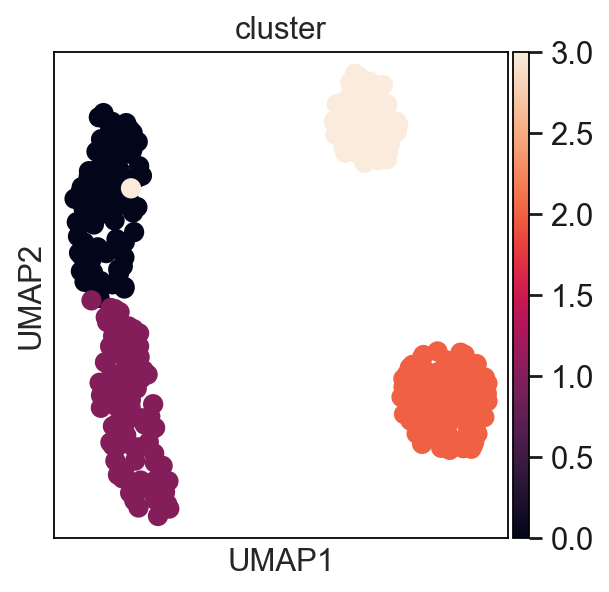


==========================  Data Processing  =================================

filtered out 6350 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Epoch 1/200
2/2 [==============================] - 2s 369ms/step - loss: 1.2595 - mae: 0.8883 - val_loss: 1.2086 - val_mae: 0.8708
Epoch 2/200
2/2 [==============================] - 0s 145ms/step - loss: 1.2311 - mae: 0.8765 - val_loss: 1.1293 - val_mae: 0.8323
Epoch 3/200
2/2 [==============================] - 0s 161ms/step - loss: 1.1828 - mae: 0.8551 - val_loss: 1.0905 - val_mae: 0.8067
Epoch 4/200
2/2 [==============================] - 0s 143ms/step - loss: 1.1414 - mae: 0.8354 - val_loss: 1.0968 - val_mae: 0.8028
Epoch 5/200
2/2 [==============================] - 0s 145ms/step - loss: 1.1166 - mae: 0.8223 - val_loss: 1.1018 - val_mae: 0.8022
Epoch 6/200
2/2 [==============================]

In [47]:
dataset_path = "data/Kumar.csv"

adata = data_init(dataset_path)

adata = data_processing(adata)

adata = Denoise(adata)

# CellTICS Marker Genes


========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.6559
Normalized Mutual Information (NMI): 0.7922
Silhouette Score: 0.4089



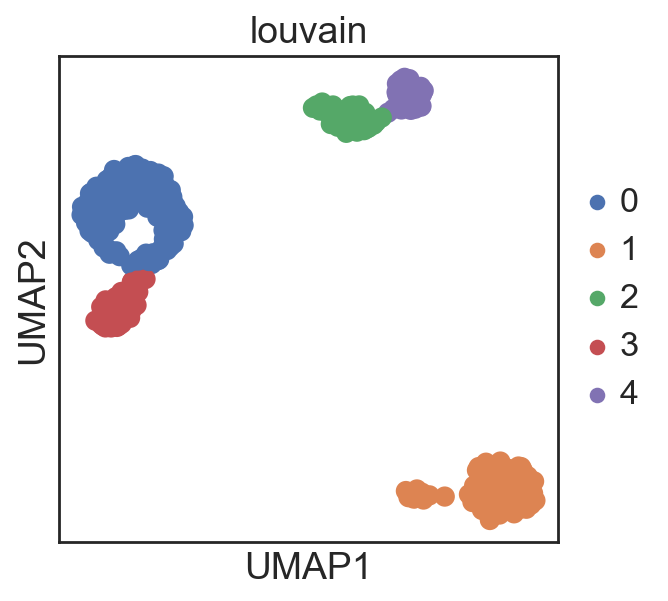


====================== Identify Marker Gene With CellTICS ============================

Expression Values of Genes: 

           cell-1    cell-2    cell-3    cell-4    cell-5    cell-6    cell-7    cell-8    cell-9   cell-10
Gene                                                                                                       
Itm2a    0.964794  0.959989  0.961244  0.976100  0.965979  0.965894  0.959806  0.951461  0.959890  0.959926
jnk1     1.064022  1.084460  0.971323  0.965609  0.984970  0.976117  0.967974  0.931751  1.057614  1.006159
Sergef   0.633125  0.526119  0.525751  0.762262  0.441862  0.601716  0.506670  0.486484  0.489942  0.555499
Fam109a  0.077213  0.073409  0.072581  0.078468  0.070021  0.079474  0.071841  0.070342  0.076936  0.077657
Dhx9     1.779797  1.874462  1.750838  1.753577  1.742087  1.821770  1.866255  1.788699  1.888904  1.844797
Ssu72    1.748737  1.755045  1.754850  1.753562  1.747013  1.762433  1.790453  1.792806  1.759437  1.756052
Eif2b2   1.485635

In [93]:
cluster_with_louvain(adata, epochs=1, resolution=0.2)
t=time.process_time()
tracemalloc.start()

high_markers, low_markers = CellTICS_marker_genes(adata, thr1=0.97, thr2= 0.90)

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()


high_markers = get_unique_marker_genes(high_markers)

# Cluster Reconstructed Dataset (CellTICS)

In [49]:
expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
expr_data = expr_data.loc[high_markers]
expr_data.shape

rcdata = sc.AnnData(X=expr_data.values.T)
rcdata.var_names = expr_data.index
rcdata.obs_names = expr_data.columns
rcdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(rcdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 361 × 819
    obs: 'cluster'


In [50]:
# rc_pd = pd.DataFrame(rcdata.X.T, index=rcdata.var_names, columns=rcdata.obs_names)
# rc_pd.to_csv('rc_processed.csv')


========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.7680
Normalized Mutual Information (NMI): 0.8443
Silhouette Score: 0.4480



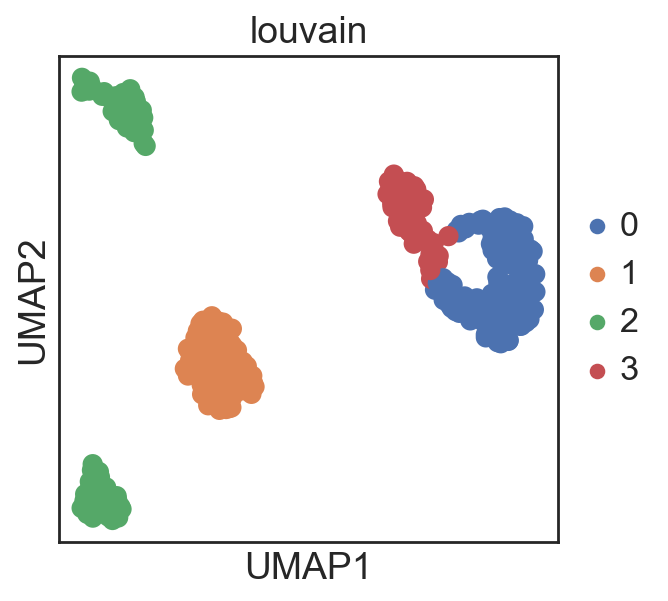

In [67]:
cellTICS_sil_scores = cluster_with_louvain(rcdata, epochs=1, resolution=0.2)

# Smash Marker Genes

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                515008    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

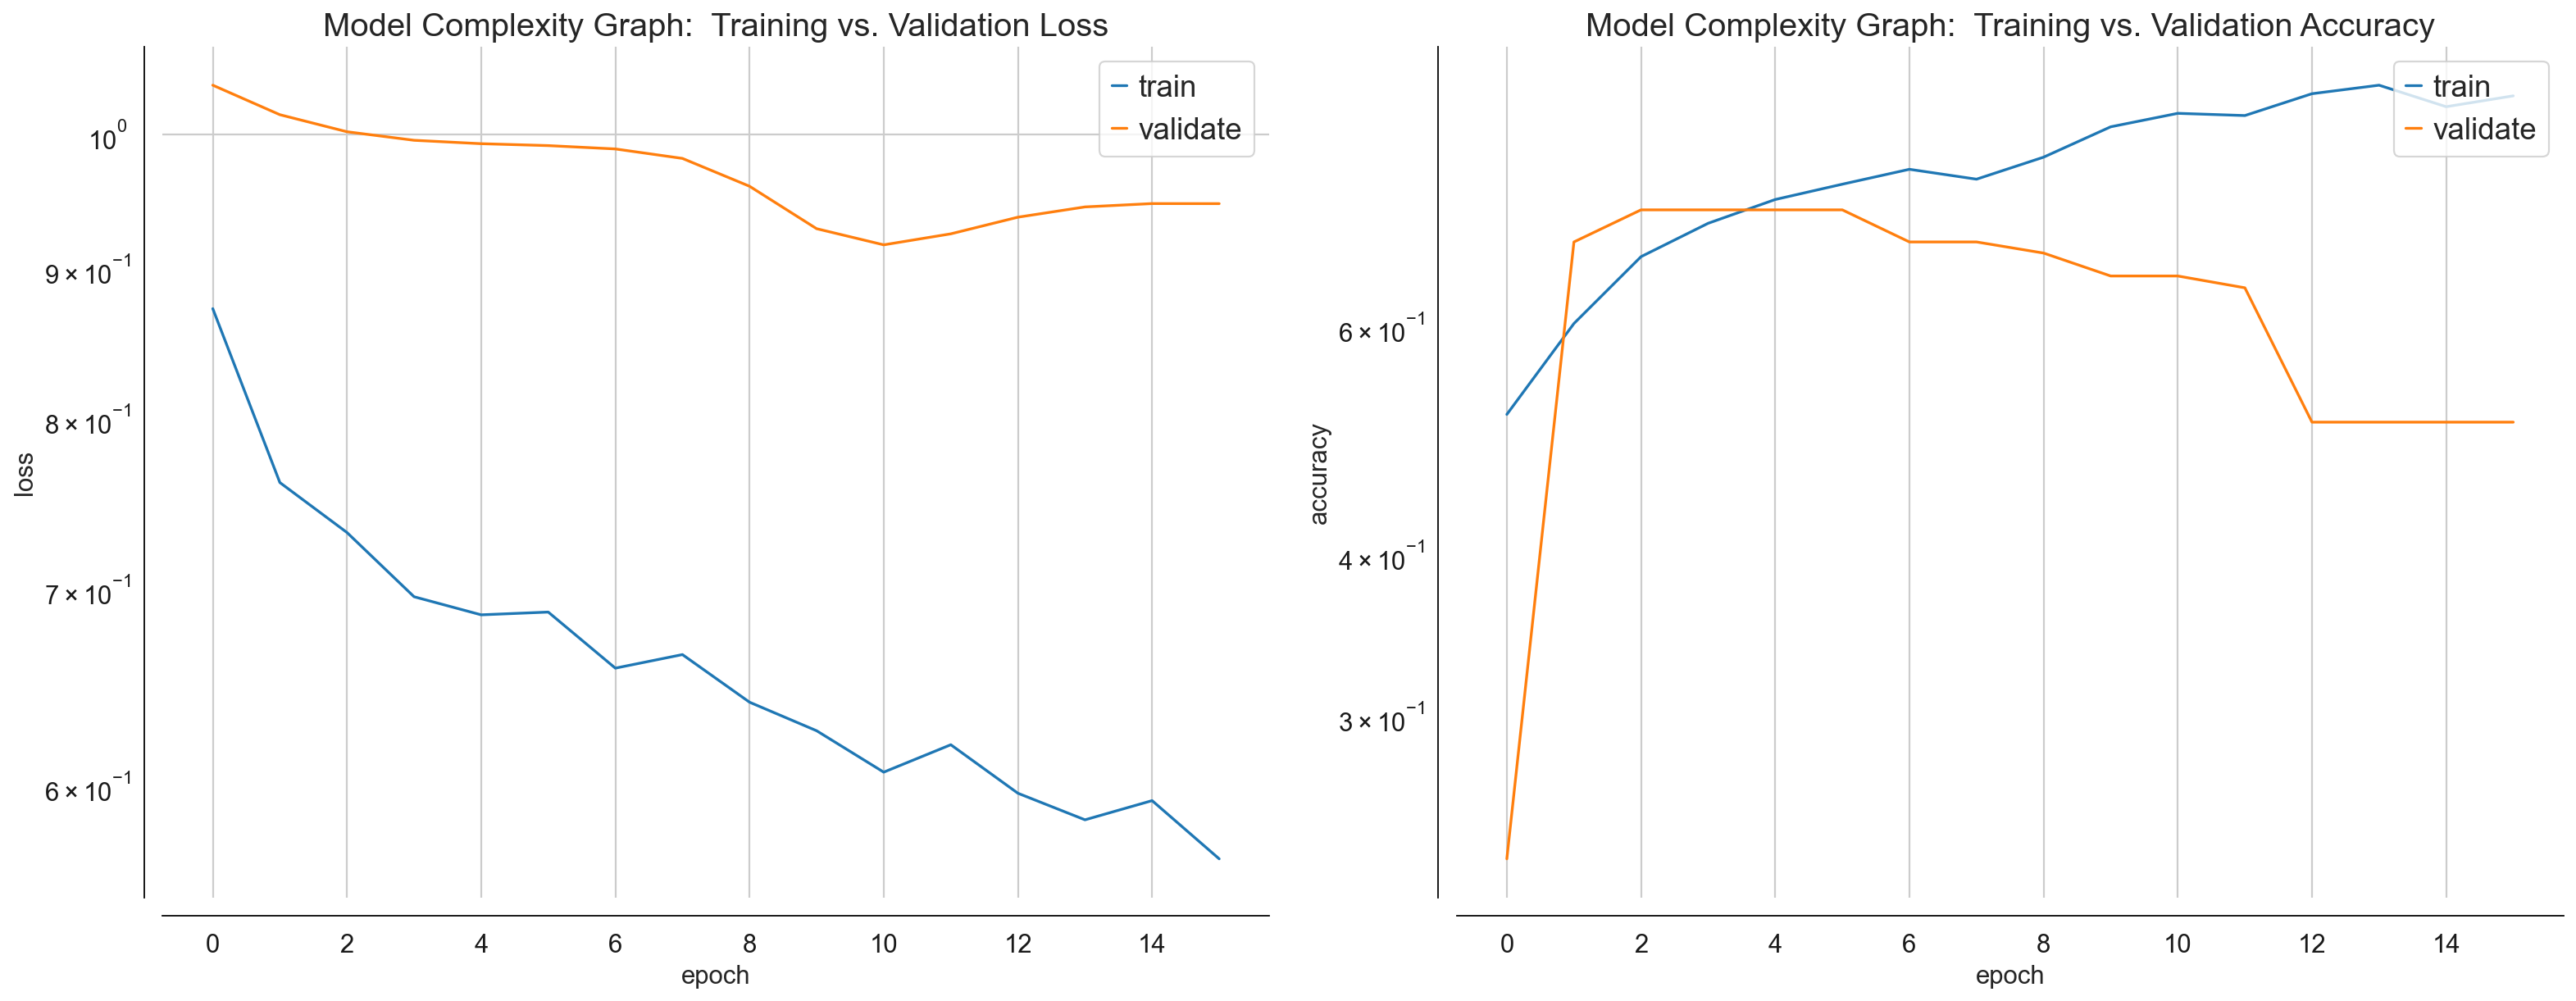

<Figure size 320x320 with 0 Axes>

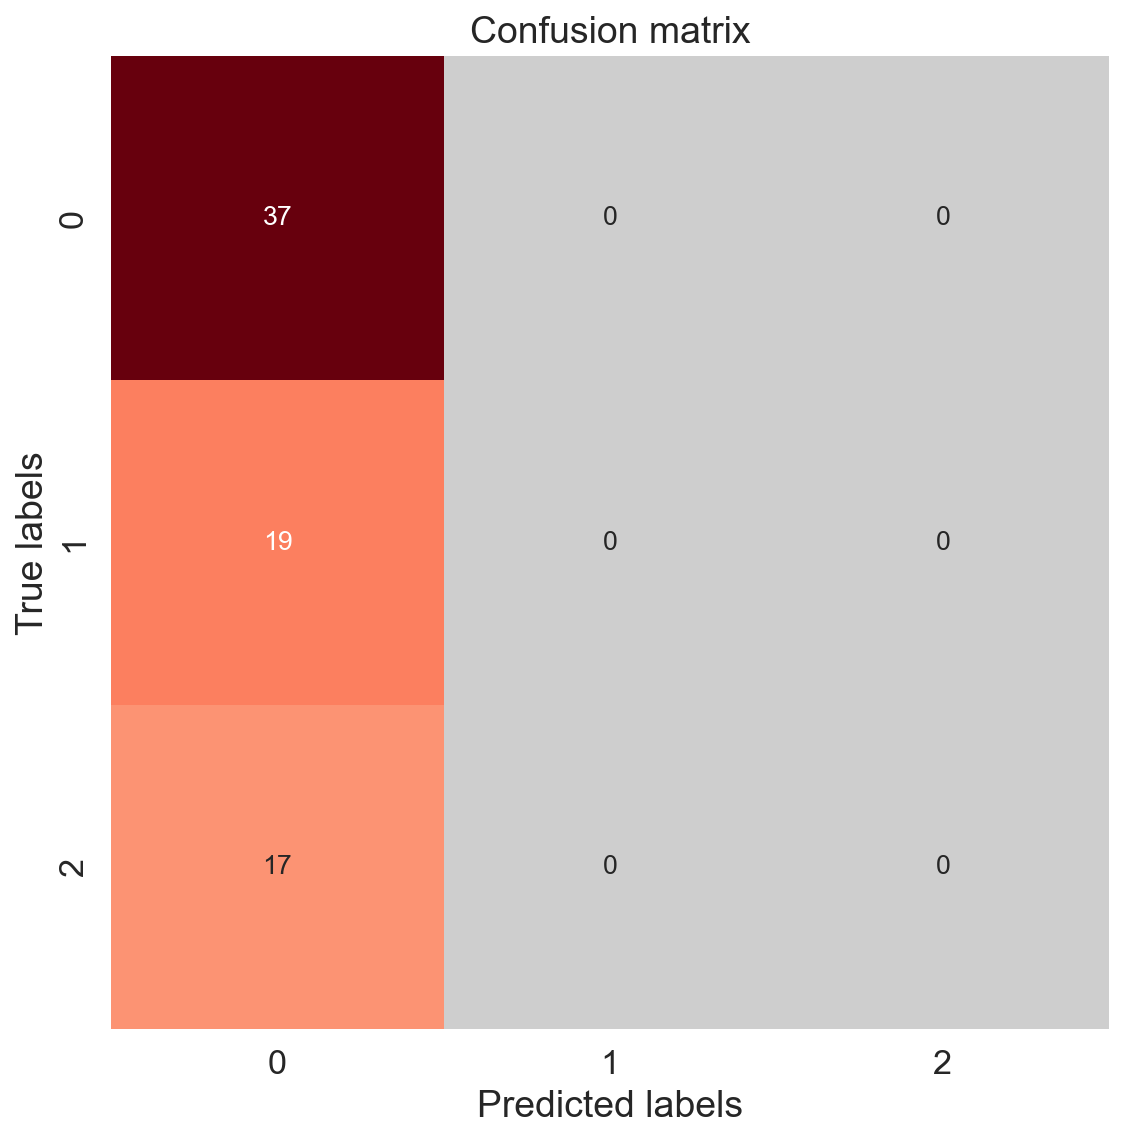

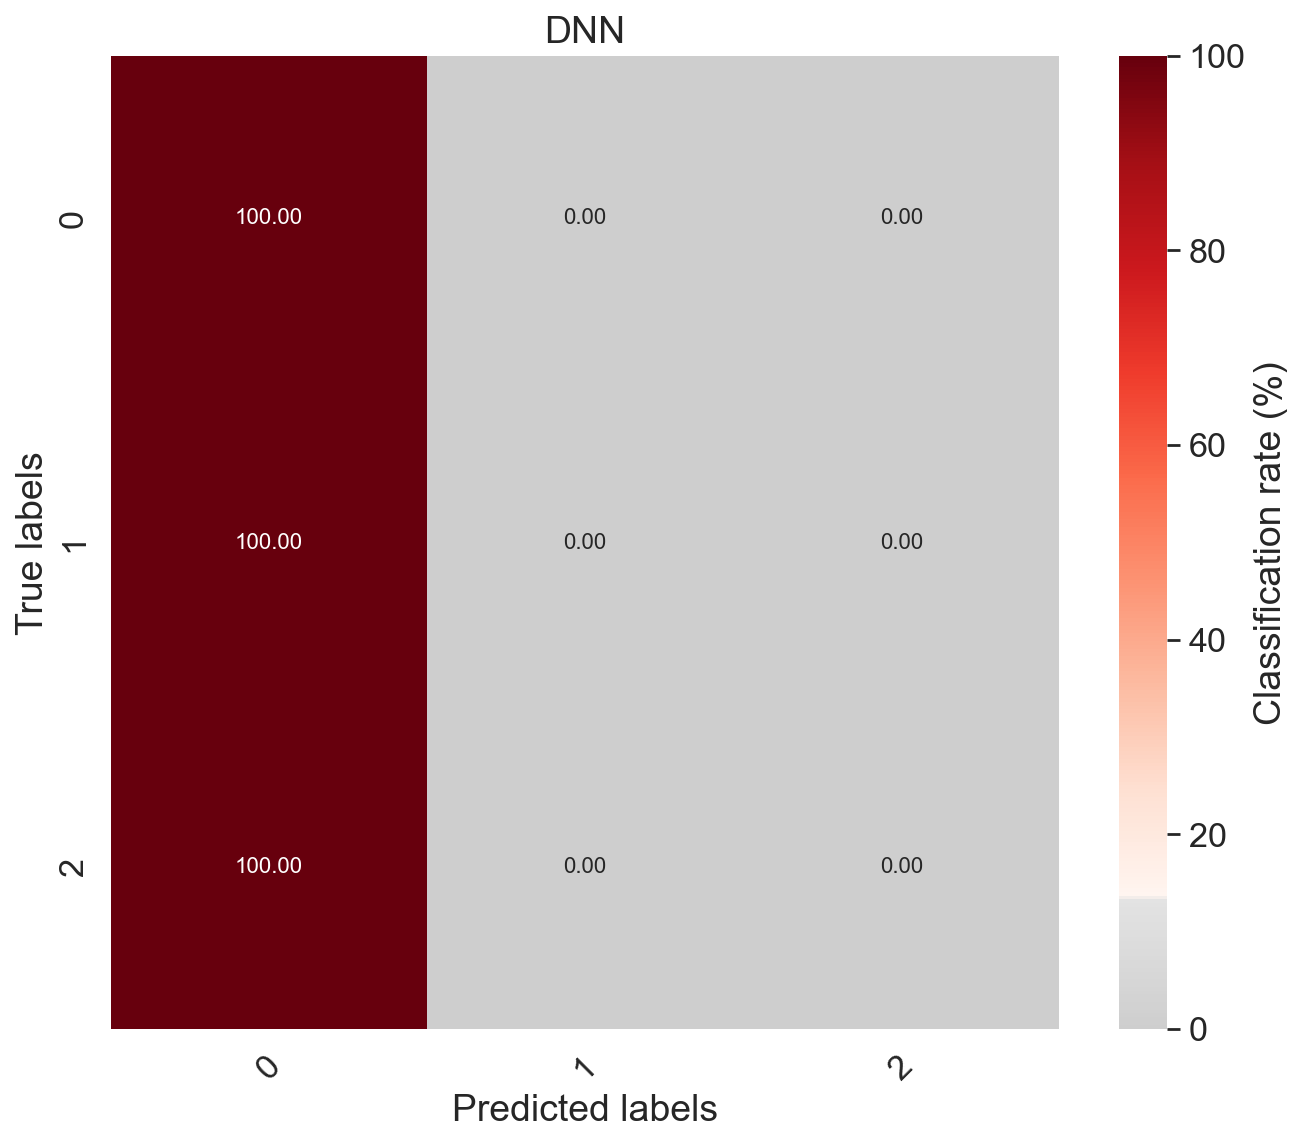

              precision    recall  f1-score   support

           0       0.51      1.00      0.67        37
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        17

    accuracy                           0.51        73
   macro avg       0.17      0.33      0.22        73
weighted avg       0.26      0.51      0.34        73

3/3 [==============================] - 0s 4ms/step - loss: 0.9172 - accuracy: 0.6575 - auc: 0.7958 - precision: 0.6607 - recall: 0.5068


In [52]:
import os
import smashpy

smash = smashpy.smashpy()

if np.any(np.isnan(adata.X)):
    adata.X = np.nan_to_num(adata.X)

if not os.path.exists('Figures'):
    os.makedirs('Figures')

smash.DNN(adata, group_by='louvain')

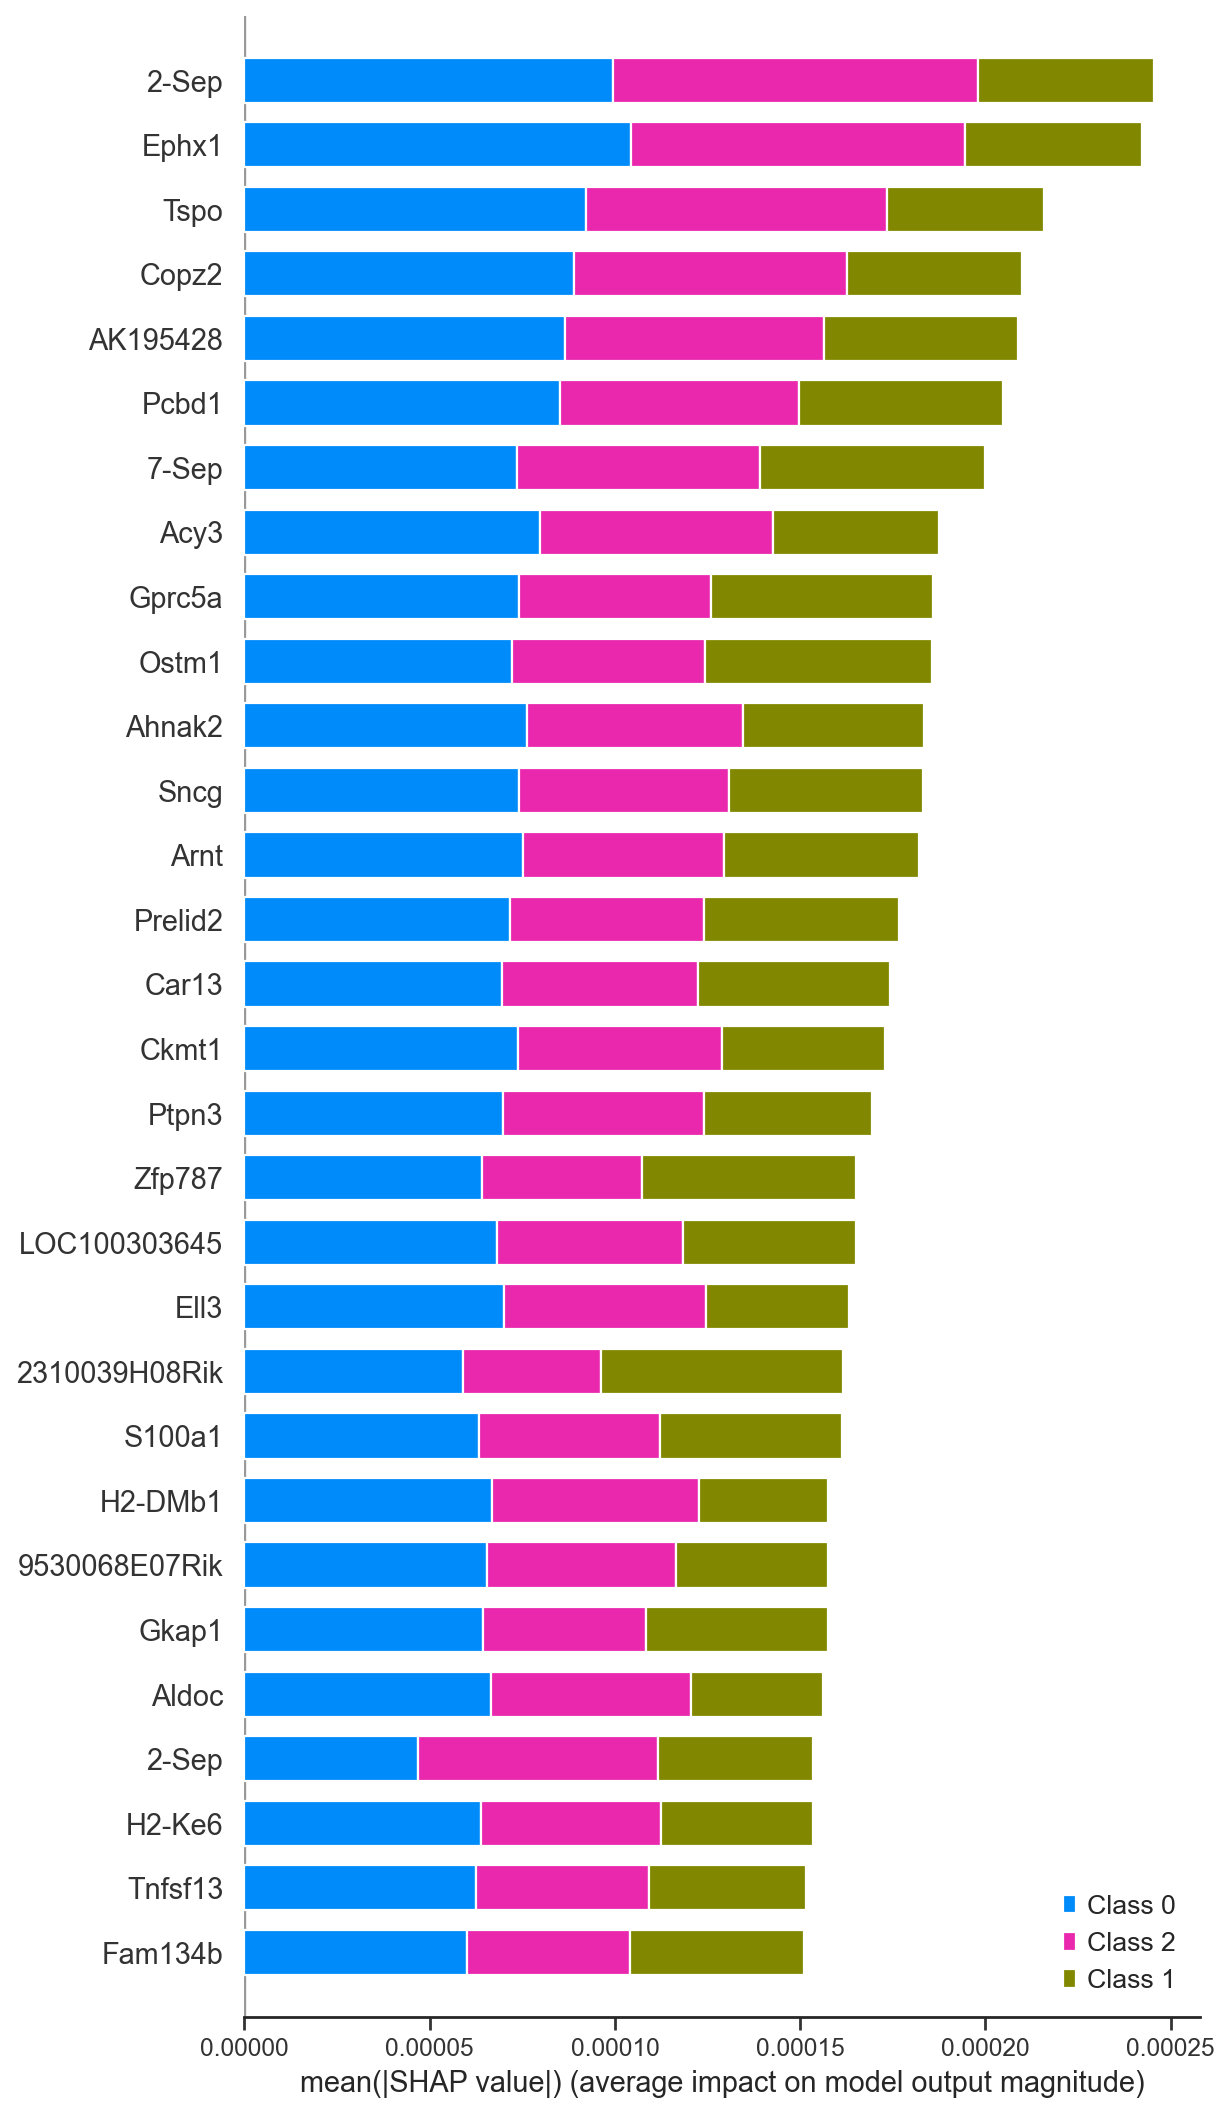

Memory Usage: 145.43 Mb
Required Time: 15.078125 sec


In [53]:

thr=0.95
n_genes = math.ceil((1 - thr) * adata.var.shape[0])


t=time.process_time()
tracemalloc.start()
# Run SHAP to identify marker genes
selected_genes, selected_genes_dict = smash.run_shap(adata, group_by='louvain', pct=0.5, restrict_top=("global", n_genes))

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()

# Cluster Reconstructed Dataset (SMaSH)


Total Marker genes (805): 

Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 361 × 821
    obs: 'cluster'

========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.7680
Normalized Mutual Information (NMI): 0.8443
Silhouette Score: 0.4480



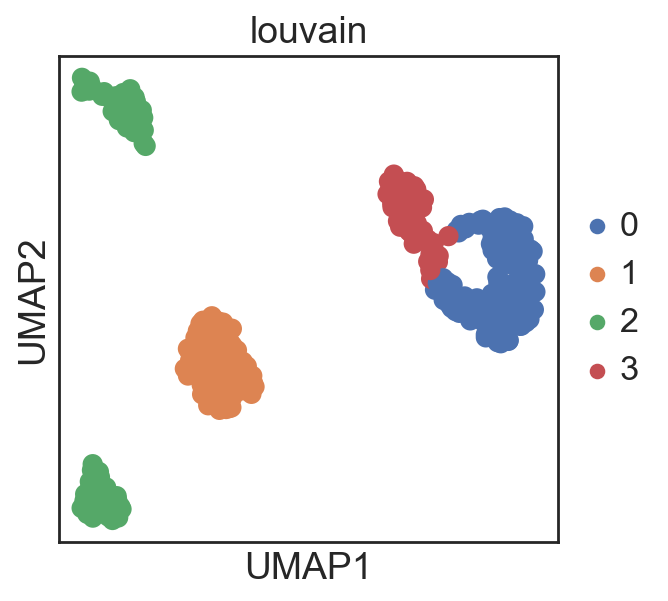

In [69]:

print(f'\nTotal Marker genes ({len(selected_genes)}): ')
expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
# expr_data.to_csv('expr_processed.csv')
# expression data with only marker genes
expr_data = expr_data.loc[selected_genes]
expr_data.shape

rcdata = sc.AnnData(X=expr_data.values.T)
rcdata.var_names = expr_data.index
rcdata.obs_names = expr_data.columns
rcdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(rcdata)
rc_pd = pd.DataFrame(rcdata.X.T, index=rcdata.var_names, columns=rcdata.obs_names)
# rc_pd.to_csv('rc_processed.csv')

if "X_pca" not in rcdata.obsm and "neighbors" not in rcdata.uns:
  sc.pp.pca(rcdata, n_comps=50)
  sc.pp.neighbors(rcdata, n_pcs=50)
smash_sil_scores = cluster_with_louvain(rcdata, epochs=1, resolution=0.2)

# Cosg Marker Genes

In [55]:
import cosg as cosg
import importlib
importlib.reload(cosg)

<module 'cosg' from 'D:\\FYDP\\Implementation\\Notebooks\\python3.8\\lib\\site-packages\\cosg\\__init__.py'>

In [56]:
t=time.process_time()
tracemalloc.start()

cosg.cosg(adata,
    key_added='cosg',
        mu=1,
        n_genes_user=100,
               groupby='louvain')

current, peak = tracemalloc.get_traced_memory()
print(f'Memory Usage: {(peak / (1024 ** 2)):.2f} Mb') #The output is given in form of (current, peak), i.e., current memory is the memory the code is currently using,uses and peak memory is the maximum space the program used while executing.
print(f'Required Time: {time.process_time() - t} sec')
tracemalloc.stop()

**finished identifying marker genes by COSG**
Memory Usage: 89.04 Mb
Required Time: 0.203125 sec


In [57]:
adata

AnnData object with n_obs × n_vars = 361 × 16093
    obs: 'cluster', 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'cosg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [58]:
# cosg_marker_genes = np.unique(np.array(adata.uns['cosg']['names'])).tolist()
cosg_marker_genes = pd.unique(pd.DataFrame(adata.uns['cosg']['names']).values.ravel()).tolist()

In [59]:
len(cosg_marker_genes)

300

# Cluster Reconstructed Dataset (Cosg)

In [60]:
cosg_expr_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
# expr_data.to_csv('expr_processed.csv')
# expression data with only high marker genes
cosg_expr_data = cosg_expr_data.loc[cosg_marker_genes]
# expr_data = expr_data.loc[marker_genes]
cosg_expr_data.shape

cgdata = sc.AnnData(X=cosg_expr_data.values.T)
cgdata.var_names = cosg_expr_data.index
cgdata.obs_names = cosg_expr_data.columns
cgdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(cgdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 361 × 315
    obs: 'cluster'



========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.7263
Normalized Mutual Information (NMI): 0.8269
Silhouette Score: 0.5360



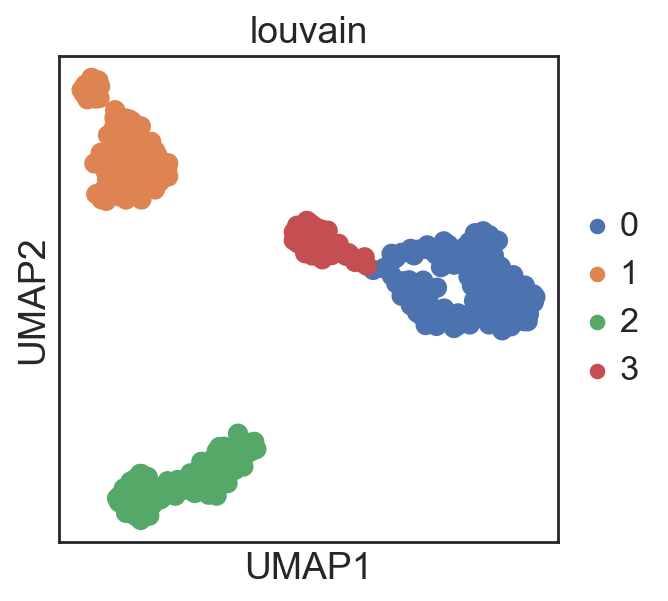

In [70]:

if "X_pca" not in cgdata.obsm and "neighbors" not in cgdata.uns:
  sc.pp.pca(cgdata, n_comps=50)
  sc.pp.neighbors(cgdata, n_pcs=50)
cosg_sil_scores = cluster_with_louvain(cgdata, epochs=1, resolution=0.2)

# Unified Marker Genes (CellTICS + COSG+ SMaSH)

In [71]:
silhouette_scores = {
    'celltics': cellTICS_sil_scores,
    'cosg': cosg_sil_scores,
    'smash': smash_sil_scores
}
print('silhouette scores: ', silhouette_scores)
methods_importance = calculate_importance(silhouette_scores)
print('methods_importance: ', methods_importance)

silhouette scores:  {'celltics': [0.44798616], 'cosg': [0.5360498], 'smash': [0.44798616]}
methods_importance:  {'celltics': 0.31283466742453303, 'cosg': 0.37433066515093394, 'smash': 0.31283466742453303}


In [89]:
# getting genes with highest weights
# methods_importance = {
#     'celltics': 0.349,
#     'cosg': 0.382,
#     'smash': 0.267
# }
UMG = pd.unique(score_marker_genes(high_markers,cosg_marker_genes,selected_genes, methods_importance, p=0.70))

total genes: 1645
selected genes: 1151


In [90]:
len(UMG)

1151

In [91]:
exp_data = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
exp_data = exp_data.loc[UMG]

ccdata = sc.AnnData(X=exp_data.values.T)
ccdata.var_names = exp_data.index
ccdata.obs_names = exp_data.columns
ccdata.obs["cluster"] = adata.obs["cluster"]
print("\nReconstructed data from marker genes:")
print(ccdata)


Reconstructed data from marker genes:
AnnData object with n_obs × n_vars = 361 × 1164
    obs: 'cluster'



========================== Clustering With Louvain =================================


Clustering epoch 1 ------------------
Adjusted Rand Index (ARI): 0.7444
Normalized Mutual Information (NMI): 0.8426
Silhouette Score: 0.4719



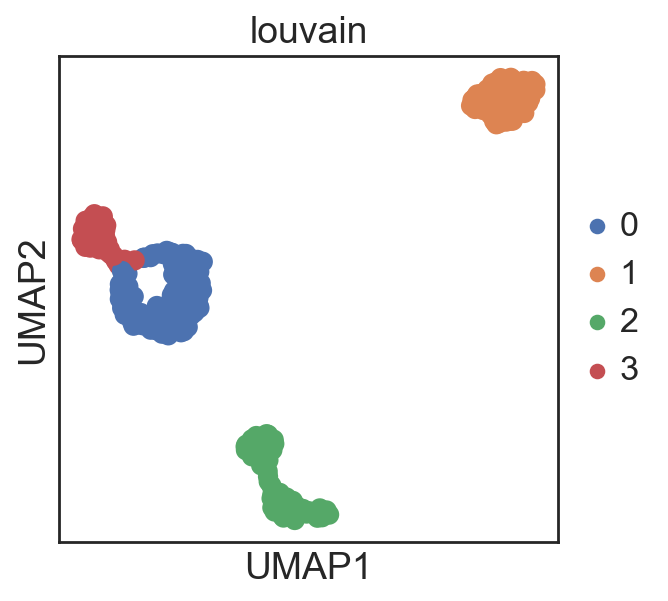

[0.4719316]

In [94]:

if "X_pca" not in ccdata.obsm and "neighbors" not in ccdata.uns:
  sc.pp.pca(ccdata, n_comps=50)
  sc.pp.neighbors(ccdata, n_pcs=50)
cluster_with_louvain(ccdata, epochs=1, resolution=0.2)